<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training

## Installing dependencies:

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install "gymnasium[classic_control]" > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

# Added dependency
!pip install tensorflow > /dev/null 2>&1
!pip install imageio > /dev/null 2>&1
!pip install PIL > /dev/null 2>&1
!pip install opencv-python > /dev/null 2>&1
!pip instal moviepy > /dev/null 2>&1



# Start testing from here

## Import libraries and dependencies

In [1]:
import time
from collections import deque, namedtuple
import random

import gymnasium as gym
from   gym          import logger as gymlogger
from   gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE # Mean Square Error
from tensorflow.keras.optimizers.legacy import Adam


# This library is defined to generate and display the result video
import utils

## Import the model

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

## Define some Constants and Parameters

In [3]:
MEMORY_SIZE = 1_000_000     # size of memory buffer
GAMMA = 0.99              # discount factor
ALPHA = 1e-4              # learning rate  
NUM_STEPS_FOR_UPDATE = 20  # perform a learning update every C time steps

STATE_SIZE = env.observation_space.shape  # The model can return 4 state attributes
NUM_OF_ACTION = env.action_space.n        # the model can only use 2 action push_left(0), push_right(1)

MINIBATCH_SIZE = 10  # Mini-batch size.
TAU = 0.005          # Soft update parameter.
E_DECAY = 0.9995     # ε-decay rate for the ε-greedy policy.
E_MIN = 0.047        # Minimum ε value for the ε-greedy policy.
SEED = 0


## Some notes about the model
Reference: <a href = https://gymnasium.farama.org/environments/classic_control/cart_pole/> Cart Pole documentation</a>

### Actions:
- Variable type: `ndarray (1,)`
```python
PUSH_LEFT  = 0
PUSH_RIGHT = 1
```
### States (observations):
- Variable type: `ndarray (4,)`<br>

| Index | Observation | Min | Max |
|:-------:|:-------------:|:-----:|:-----:|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-Inf|Inf|
|2|Pole Angle|-0.418|0.418|
|3|Pole Angular Velocity|-Inf|Inf|

### Reward:
`+1` for every step (including terminal state)

### Episode end:
- Termination: Pole Angle outside of $\pm 12^{\circ}$
- Termination: Cart Position outside of $\pm 2.4$
- Truncation: Episole length > 500



## Deep-Q learning

- In the lecture, we apply Q-Learning by creating a `State, Action` Table to capture the `Q(s, a)` and since we are in a continuous environment it is quite difficult to capture all the states in the same table.<br>
- Therefore, it is better to use the weights in the Deep Neural Network (DNN) to capture all that information. <br>


Moreover, it could behave like a Q-value table, since you can get Q(s, a) by just calling 

```python
q_network(state)[a]
``` 
and update it by training the neural network through loss function (Mean Square Error) to approximate the true value which behave just like what describe in the lecture.<br>
- The true value:
$$y=R(s, a)+\gamma max_a(Q_{network}(s', a'))$$
- The prediction:
$$\hat{y} = Q_{network}(s)$$

### The Q-network problem

One action `a` of the agent may lead to many possible $y$ since `Q_network` is involve in the calculation of $y$, which could make the model become unstable in the training process. So we will need another DNN (with identical structure to `Q_network`) to return the `Q(s', a')` called `target_Q_network`. i.e.

$$y=R(s,a)+\gamma max_a(TargetQ_{network}(s',a'))$$
and
$$\hat{y} = Q_{network}(s)$$

The `target_Q_network` and `Q_network` will be updated (trained) after a certain amount of steps.
- `Q_network`'s weights $w$ will still be updated using the loss computed from $y$ and $\hat{y}$ with learning rate $\alpha$.
- `Target_Q_network`'s weights $w^-$ will be update using soft update technique where it keep most of the part from the last experience and a small update based on the actual change of $w$. It will create a smoother learning curve and become more stable in the long run.

$$
w^- \leftarrow \tau w + (1-\tau)w^-
$$
where $\tau << 1$


We will define each layer of both DNN:
- `INPUT`: no. of units = `STATE_SIZE`
- `DENSE`: 64 units of 'relu' activate function
- `DENSE`: 64 units of 'relu' activate function
- `DENSE`: output layers with no. of units = `NUM_OF_ACTION` with 'linear' activate function

### Q_network and Target_Q_network stucture

In [4]:
q_network = Sequential([
    Input(shape = STATE_SIZE),
    Dense(units = 128, activation = 'relu'),
    Dense(units = 256, activation = 'relu'),
    Dense(units = NUM_OF_ACTION, activation = 'linear')
])

target_q_network = Sequential([
    Input(shape = STATE_SIZE),
    Dense(units = 128, activation = 'relu'),
    Dense(units = 256, activation = 'relu'),
    Dense(units = NUM_OF_ACTION, activation = 'linear')
])

# Optimizer will update the learning rate appropriately to help speed up the training process
optimizer = Adam(learning_rate=ALPHA) 

### Soft update function for Target_Q_Network

In [5]:
def update_target_network(q_network, target_q_network):

    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)


### Experience Relay

In Deep-Q Learning, when we record the experience in the sequence it will create a lot of correlation between the consecutive states which may create bias in our model.<br>
To account for this, we will create a collection of experience and develop a function to sample the data randomly.

In [6]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [7]:
#random.seed(SEED)
def get_experiences(memory_buffer):
    
    experiences = random.sample(memory_buffer, k = MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)

### Create a Loss function

In [8]:
def compute_loss(experiences, gamma, q_network, target_q_network):


    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    
    
    
    
    
    
    
    
    
    
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (1 - done_vals) * (gamma * max_qsa)


    
    
    
    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    loss = MSE(y_targets, q_values)

    
    return loss

### Create a function to update the weight of both network model

This is the stage where the 2 models update their weight (train the weight) accordingly

In [9]:
@tf.function
def agent_learn(experiences, gamma):
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

### Check update function

In [14]:
def check_update_conditions(t, num_steps_upd, memory_buffer):

    if len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

## $\varepsilon$-greedy action choice

- We will defined the $\varepsilon$ at the beginning of the training stage<br>
- We will take action $a^{*}$ which could maximize the $Q(s, a)$ if the probability is greater than $\varepsilon$, else we will choose the action at random, because there could be the case where random action could be better


In [11]:
def get_action(q_values, epsilon = 0.0):

    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(2))

However, overtime the agent (model) have learned and improve a lot so we have to decay the $\varepsilon$ value with rate `E_DECAY`, i.e. the model will take action based on what it has learned more frequently. We also put a lower threshold of $\varepsilon$ (`E_MIN`) to allow the model the chance to do random action sometime.

In [12]:
def get_new_eps(epsilon):
    
    return max(E_MIN, E_DECAY * epsilon)

### Training step

After the training time when we obtain the average value > 200, we consider our model is good to deploy and we deploy our trained parameters into .h5 file

In [15]:
num_episodes = 10_000_000
max_num_timesteps = 500

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen = MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()[0]
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis = 0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, truncated, info = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        
        
        #total_points += reward
        total_points += 1
        
        
        if done:
            break
            

            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    

    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('cart_pole_model.h5')
        break
        

Episode 100 | Total point average of the last 100 episodes: 21.59
Episode 200 | Total point average of the last 100 episodes: 20.98
Episode 300 | Total point average of the last 100 episodes: 24.51
Episode 400 | Total point average of the last 100 episodes: 31.53
Episode 500 | Total point average of the last 100 episodes: 26.81
Episode 600 | Total point average of the last 100 episodes: 36.24
Episode 700 | Total point average of the last 100 episodes: 38.34
Episode 800 | Total point average of the last 100 episodes: 41.00
Episode 900 | Total point average of the last 100 episodes: 49.42
Episode 999 | Total point average of the last 100 episodes: 45.36

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


Episode 1000 | Total point average of the last 100 episodes: 45.28
Episode 1100 | Total point average of the last 100 episodes: 46.92
Episode 1200 | Total point average of the last 100 episodes: 56.40
Episode 1300 | Total point average of the last 100 episodes: 61.02
Episode 1400 | Total point average of the last 100 episodes: 65.67
Episode 1500 | Total point average of the last 100 episodes: 80.40
Episode 1600 | Total point average of the last 100 episodes: 104.89
Episode 1700 | Total point average of the last 100 episodes: 120.86
Episode 1800 | Total point average of the last 100 episodes: 132.39
Episode 1900 | Total point average of the last 100 episodes: 149.22
Episode 1999 | Total point average of the last 100 episodes: 166.35

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


Episode 2000 | Total point average of the last 100 episodes: 167.08
Episode 2073 | Total point average of the last 100 episodes: 201.04

Environment solved in 2073 episodes!


/Users/nguyentuan/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
utils.create_video("video/video.mp4", env, q_network, test = False)

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


In [2]:
utils.show_video()

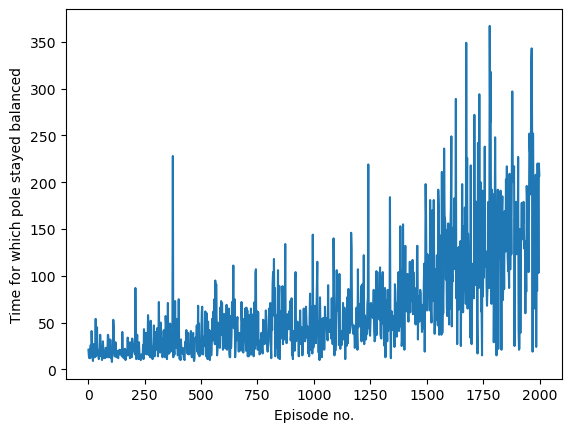

In [29]:
plt.plot([i+1 for i in range(0, 2000,2)], total_point_history[:2000:2])
plt.xlabel('Episode no.')
plt.ylabel('Time for which pole stayed balanced')
plt.show()